In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump

# Load the labeled data from the CSV file
df = pd.read_csv("D:/PodiumPro/labeled_audio_results.csv")

# Split the data into features (X) and labels (y)
X = df[["Articulation Rate", "Filler Word Count", "Average F0", "Speech Rate", "Speech Mood"]]
y = df["Label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train an SVM classifier
svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X_train, y_train)

# Extract feature coefficients
feature_coefficients = svm_classifier.coef_

# Print or visualize the feature coefficients
print("Feature Coefficients:", feature_coefficients)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

# Save the trained model and feature coefficients
dump(svm_classifier, 'svm2.joblib')
dump(feature_coefficients, 'svm2_coefficients.joblib')


Feature Coefficients: [[ 2.40855501e-04 -1.70235048e-01  3.01828791e-02  1.44517433e-02
  -1.17900012e+00]
 [ 1.73897112e-03 -3.34470616e-03  3.33021406e-04  1.04338267e-01
   2.20818632e-04]
 [ 2.10089994e-02  0.00000000e+00 -1.03651845e-02  1.26053994e+00
  -8.01833126e-03]]
Accuracy: 0.82
              precision    recall  f1-score   support

      Expert       0.92      0.71      0.80       120
Intermediate       0.70      0.92      0.79        87
       Naive       1.00      1.00      1.00        21

    accuracy                           0.82       228
   macro avg       0.87      0.88      0.86       228
weighted avg       0.84      0.82      0.82       228



['svm2_coefficients.joblib']

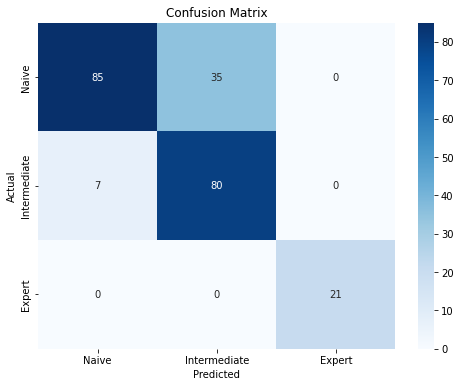

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the 'y_test' and 'y_pred' variables from the previous code

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Naive", "Intermediate", "Expert"], yticklabels=["Naive", "Intermediate", "Expert"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [7]:
!pip install SpeechRecognition
import nltk
nltk.download('punkt')



Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 32.8/32.8 MB 9.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghanc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [12]:
import joblib
import numpy as np
import librosa
import speech_recognition as sr
import nltk
from textblob import TextBlob
import re

# Function to extract features from audio (similar to your feature extraction logic)
def extract_audio_features(audio_file):
    # Load and process the audio file using Librosa
    sample_rate = librosa.get_samplerate(audio_file)
    y, sr_librosa = librosa.load(audio_file, sr=sample_rate)

    # Gender Recognition (Use a pre-trained model or API)
    # Implement gender recognition logic here and set 'gender' variable

    # Speech-to-Text Conversion
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio = recognizer.record(source)

    transcribed_text = recognizer.recognize_google(audio)

    # Tokenize the transcribed text into words for articulation rate
    words = nltk.word_tokenize(transcribed_text)

    # Calculate the articulation rate (words per second)
    duration_of_speech = len(y) / sr_librosa  # in seconds
    articulation_rate = len(words) / duration_of_speech

    # Calculate speech rate (words per minute)
    speech_rate = len(words) / (duration_of_speech / 60)

    # Sentiment Analysis (Speech Mood)
    text_blob = TextBlob(transcribed_text)
    speech_mood = text_blob.sentiment.polarity

    # Filler Words Detection
    # Define a list of common filler words
    filler_words = ["um", "uh", "like", "you know", "so", "actually", "basically", "literally", "totally", "seriously", "well", "anyway", "apparently", "honestly", "right", "I mean", "sort of", "kind of"]

    # Count the occurrences of filler words
    filler_word_count = 0
    for word in filler_words:
        filler_word_count += len(re.findall(r'\b' + word + r'\b', transcribed_text, flags=re.IGNORECASE))

    # F0 Statistics (Fundamental Frequency)
    # You may need a separate library or model to calculate F0 statistics
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    average_f0 = f0[f0 > 0].mean()

    # Return extracted features as a NumPy array
    return np.array([articulation_rate, filler_word_count, average_f0, speech_rate, speech_mood])

# Load the trained SVM model and feature coefficients
model = joblib.load('svm2.joblib')
feature_coefficients = joblib.load('svm2_coefficients.joblib')

# Replace 'new_audio_file.wav' with the path to your new audio file
new_audio_file = 'Vinod1.wav'

# Extract features from the new audio file
new_audio_data = extract_audio_features(new_audio_file)

# Ensure that 'new_audio_data' is a 1D NumPy array
# If needed, you can reshape it: new_audio_data = new_audio_data.reshape(1, -1)

# Make predictions using the loaded model
predicted_class = model.predict([new_audio_data])


# Provide feature feedback based on feature coefficients
feature_feedback = {
    "Articulation Rate": feature_coefficients[0, 0],
    "Filler Word Count": feature_coefficients[0, 1],
    "Average F0": feature_coefficients[0, 2],
    "Speech Rate": feature_coefficients[0, 3],
    "Speech Mood": feature_coefficients[0, 4],
}

print("Predicted Class:", predicted_class)
print("Feature Feedback:")
for feature, coefficient in feature_feedback.items():
    print(f"{feature}: {coefficient}")
    
# Provide feedback based on the predicted class and feature coefficients
def provide_feedback(predicted_class, feature_feedback):
    feedback_text = f"Predicted Class: {predicted_class[0]}\n\nFeature Feedback:\n"

    for feature, coefficient in feature_feedback.items():
        if feature == "Articulation Rate":
            if coefficient > 0:
                feedback_text += f"{feature}: Your articulation rate is relatively high. This is good for clarity and precision in speech. Consider maintaining or refining this aspect.\n"
            elif coefficient < 0:
                feedback_text += f"{feature}: Your articulation rate is relatively low. Consider focusing on improving clarity and precision in your speech.\n"
            else:
                feedback_text += f"{feature}: Your articulation rate is at a neutral level.\n"

        elif feature == "Filler Word Count":
            if coefficient > 0:
                feedback_text += f"{feature}: There is a relatively high occurrence of filler words in your speech. Consider reducing their usage for clearer communication.\n"
            elif coefficient < 0:
                feedback_text += f"{feature}: Your usage of filler words is relatively low. Maintain or continue minimizing their use.\n"
            else:
                feedback_text += f"{feature}: Your filler word count is at a neutral level.\n"

        elif feature == "Average F0":
            if coefficient > 0:
                feedback_text += f"{feature}: Your average fundamental frequency is relatively high. Maintain or refine your pitch variation for engaging speech.\n"
            elif coefficient < 0:
                feedback_text += f"{feature}: Your average fundamental frequency is relatively low. Consider adding more pitch variation for expressive speech.\n"
            else:
                feedback_text += f"{feature}: Your average fundamental frequency is at a neutral level.\n"

        elif feature == "Speech Rate":
            if coefficient > 0:
                feedback_text += f"{feature}: Your speech rate is relatively high. Maintain or refine your current speech pace.\n"
            elif coefficient < 0:
                feedback_text += f"{feature}: Your speech rate is relatively low. Consider adjusting your speech pace for better engagement.\n"
            else:
                feedback_text += f"{feature}: Your speech rate is at a neutral level.\n"

        elif feature == "Speech Mood":
            if coefficient > 0:
                feedback_text += f"{feature}: Positive sentiment detected. Maintain a positive and engaging tone in your speech.\n"
            elif coefficient < 0:
                feedback_text += f"{feature}: Negative sentiment detected. Consider incorporating more positive expressions for a more favorable communication style.\n"
            else:
                feedback_text += f"{feature}: Your speech mood is at a neutral level.\n"

    return feedback_text

feedback_text = provide_feedback(predicted_class, feature_feedback)
print(feedback_text)


Predicted Class: ['Intermediate']
Feature Feedback:
Articulation Rate: 0.0002408555009196789
Filler Word Count: -0.1702350481516195
Average F0: 0.030182879127096385
Speech Rate: 0.014451743314566556
Speech Mood: -1.1790001219731434
Predicted Class: Intermediate

Feature Feedback:
Articulation Rate: Your articulation rate is relatively high. This is good for clarity and precision in speech. Consider maintaining or refining this aspect.
Filler Word Count: Your usage of filler words is relatively low. Maintain or continue minimizing their use.
Average F0: Your average fundamental frequency is relatively high. Maintain or refine your pitch variation for engaging speech.
Speech Rate: Your speech rate is relatively high. Maintain or refine your current speech pace.
Speech Mood: Negative sentiment detected. Consider incorporating more positive expressions for a more favorable communication style.



C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
